In [1]:
import glob
import sys
import subprocess
import numpy as np
import pandas as pd

sys.path.append("/u/lukas.rilling/dev/")

from returnn_training_progress import get_epoch_data
from returnn_training_plot_nb import plot_df
%load_ext autoreload
%autoreload 2

In [2]:
base_dir = "/u/lukas.rilling/experiments/glow_tts_asr_v2/output/"
wer_files = str(
    subprocess.check_output(
        f"find {base_dir} -type l -name 'wer' -not -path '*swer*' | grep -E 'dev-other' | grep -E -v 'jaist_project'",
        shell=True,
    ),
    "utf-8",
).split("\n")[:-1]

wer_files

['/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/librispeech_glow_asr/pytorch/conformer/asr_dataset/spec_augment_before/glow_enc192_not_pretrained/default_250/dev-other/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/librispeech_glow_asr/pytorch/conformer/asr_dataset/spec_augment_before/glow_enc192_not_pretrained/lm_tuning/lm1.5_ps0.5/default_250/dev-other/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/librispeech_glow_asr/pytorch/conformer/asr_dataset/spec_augment_before/glow_enc192_not_pretrained/lm_tuning/lm2.0_ps0.5/default_250/dev-other/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/librispeech_glow_asr/pytorch/conformer/asr_dataset/spec_augment_before/glow_enc192_not_pretrained/lm_tuning/lm2.5_ps0.3/default_250/dev-other/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/librispeech_

In [3]:
wer_files_first_index = []
experiment_group = []
wers = []
for i, f in enumerate(wer_files):
    with open(f, "r") as ff:
        wers.append(float(ff.readline().replace("\n", "")))
    folders = [
        "ASR_only",
        "joint_training/default",
        "joint_training/conformer_coupling",
        "joint_training/given_alignments",
    ]
    found = False
    for folder in folders:
        if folder in f:
            experiment_group.append(folder)
            found = True
            break
    assert len(wers) == len(experiment_group), f"Can't find this experiment group: {f}"

    possible_splitter = ["search_params", "lm_tuning", "tuning", "tuned"]
    splitter = ""
    for s in possible_splitter:
        if s in f:
            splitter = s
            break
    if splitter == "":
        wer_files_first_index.append(
            f.replace("default_250/dev-other/sclite/wer", "").replace("search/dev-other/sclite/wer", "")
        )
    else:
        wer_files_first_index.append(f[: f.index(splitter)])

assert len(wers) == len(wer_files_first_index) and len(wers) == len(
    experiment_group
), f"Well wer has length: {len(wers)} and experiment_group has length {len(experiment_group)}"

In [4]:
index = pd.MultiIndex.from_arrays([experiment_group, wer_files_first_index, wer_files], names=("Group", "Experiment", "Tuning"))

df = pd.DataFrame({"WER (dev-other)": wers}, index=index)

In [5]:
print(df.to_markdown())

|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   WER (dev-other) |
|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
count_series = df.index.get_level_values("Experiment").value_counts()

df["Count"] = df.index.get_level_values("Experiment").map(count_series)
df["Tuned"] = df["Count"] > 3

In [7]:
df_grouped = df.groupby(level=["Group","Experiment"]).min()

In [8]:
ctc_scores = []
ctc_dev_scores = []
ctc_devtrain_scores = []
overfitting = []
mle_scores = []
dp_scores = []
lr = []
finished = []
joint = []
for index, series in df_grouped.iterrows():
    data = get_epoch_data((f"{index[1]}training/work/learning_rates").replace("output", "alias"), None)
    breakpoint()
    if data is None or "ctc" not in  data[list(data.keys())[-1]]["error"]:
        if data is None:
            finished.append(True)
        else:
            finished.append(False)
        ctc_scores.append(np.nan)
        ctc_dev_scores.append(np.nan)
        ctc_devtrain_scores.append(np.nan)
        mle_scores.append(np.nan)
        dp_scores.append(np.nan)
        overfitting.append(np.nan)
    else:
        last_epoch_data = data[list(data.keys())[-1]]
        finished.append(True)
        ctc_scores.append(last_epoch_data["error"]["ctc"])
        ctc_dev_scores.append(last_epoch_data["error"]["dev_loss_ctc"])
        if "devtrain_loss_ctc" in last_epoch_data["error"]:
            ctc_devtrain_scores.append(last_epoch_data["error"]["devtrain_loss_ctc"])
            overfitting.append(ctc_dev_scores[-1] / ctc_scores[-1])
        else:
            ctc_devtrain_scores.append(np.nan)
            overfitting.append(np.nan)

        if "mle" in last_epoch_data["error"]:
            breakpoint()
            mle_scores.append(last_epoch_data["error"]["devtrain_loss_mle"])
            dp_scores.append(last_epoch_data["error"]["devtrain_loss_dp"])
        else:
            mle_scores.append("-")
            dp_scores.append("-")

df_grouped["CTC"] = ctc_scores
df_grouped["dev CTC"] = ctc_dev_scores
df_grouped["overfitting"] = overfitting
df_grouped["dev MLE"] = mle_scores
df_grouped["dev DP"] = dp_scores
df_grouped["Joint"] = [True if x != "-" and x != False and not np.isnan(x) else False for x in mle_scores]
df_grouped["Still running"] = [not x for x in finished]
df_grouped["Training data available"] = (df_grouped["CTC"] != np.nan)

In [9]:
from returnn.config import Config as ReturnnConfig

df_indexed = df_grouped.reset_index()

returnn_configs = []
for i in df_indexed.itertuples():
    experiment_path = i[2]
    returnn_config_path = experiment_path.replace("output", "alias") + "training/output/returnn.config"
    returnn_configs.append(ReturnnConfig())
    try:
        returnn_configs[-1].load_file(returnn_config_path)
    except AssertionError:
        returnn_configs[-1] = False

In [10]:
lr = []
num_epochs = []
asr_model_type = []

for i in df_indexed.itertuples():
    if returnn_configs[i[0]]:
        if returnn_configs[i[0]].has("learning_rates"):
            learning_rates = np.array(eval(returnn_configs[i[0]].value("learning_rates", "default")))
            lr_argmax = learning_rates.argmax()
            lr.append(
                f"[0: {learning_rates[0]}, {lr_argmax}: {learning_rates[lr_argmax]}, {lr_argmax + 1}: {learning_rates[lr_argmax + 1]}, {returnn_configs[i[0]].value('num_epochs', '-')}: {learning_rates[-1]}]"
            )
        elif returnn_configs[i[0]].has("learning_rate"):
            lr.append(returnn_configs[i[0]].value("learning_rate", "-"))
        else:
            lr.append("-")

        num_epochs.append(int(returnn_configs[i[0]].value("num_epochs", "-")))
    else:
        lr.append("-")
        num_epochs.append("-")

    if "conformer" in i[2]:
        asr_model_type.append("conformer")
    elif "blstm" in i[2]:
        asr_model_type.append("blstm")
    else:
        asr_model_type.append("unknown")

df_indexed["Num Epochs"] = num_epochs
df_indexed["LR"] = lr
df_indexed["ASR Model Type"] = asr_model_type


In [11]:
df_final = df_indexed.round(decimals=3)
df_final = df_final.fillna("-")
df_final["Missing glow.eval"] = df_final["Experiment"].str.contains("glow_not_eval")

## Untuned

In [12]:
print(df_final[~df_final["Tuned"]].to_markdown())

|     | Group                           | Experiment                                                                                                                                                                                                                                |   WER (dev-other) |   Count | Tuned   |   CTC |   dev CTC |   overfitting | dev MLE             | dev DP              | Joint   | Still running   | Training data available   |   Num Epochs | LR                                               | ASR Model Type   | Missing glow.eval   |
|----:|:--------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|------:|----------:|--------------:|:--------------------|:--------------------|:--------|:----------------|:-------------

In [13]:
df_tuned = df_final[df_final["Tuned"]]

In [14]:
print(df_tuned[(~df_tuned["Joint"]) & (~df_tuned["Still running"]) & (df_tuned["ASR Model Type"] == "blstm")].to_markdown())

|     | Group                | Experiment                                                                                                                                                                                                |   WER (dev-other) |   Count | Tuned   |   CTC |   dev CTC |   overfitting | dev MLE   | dev DP   | Joint   | Still running   | Training data available   |   Num Epochs | LR                                             | ASR Model Type   | Missing glow.eval   |
|----:|:---------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|------:|----------:|--------------:|:----------|:---------|:--------|:----------------|:--------------------------|-------------:|:-----------------------------------------------|:-----------------|:--------------------|
|  52 | li

## BLSTM Results (ASR only):

In [15]:
print(
    df_final[
        (~df_final["Joint"]) & (~df_final["Still running"]) & (df_final["ASR Model Type"] == "blstm")
    ].to_markdown()
)

|     | Group                           | Experiment                                                                                                                                                                                                                                |   WER (dev-other) |   Count | Tuned   |   CTC |   dev CTC |   overfitting | dev MLE   | dev DP   | Joint   | Still running   | Training data available   |   Num Epochs | LR                                             | ASR Model Type   | Missing glow.eval   |
|----:|:--------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|------:|----------:|--------------:|:----------|:---------|:--------|:----------------|:--------------------------|-------------:|:--------------

## Conformer (ASR only)

In [16]:
print(
    df_final[
        (~df_final["Joint"]) & (df_final["ASR Model Type"] == "conformer")
    ].to_markdown()
)

|     | Group                             | Experiment                                                                                                                                                                                                             |   WER (dev-other) |   Count | Tuned   | CTC   | dev CTC   | overfitting   | dev MLE   | dev DP   | Joint   | Still running   | Training data available   | Num Epochs   | LR                                               | ASR Model Type   | Missing glow.eval   |
|----:|:----------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|:------|:----------|:--------------|:----------|:---------|:--------|:----------------|:--------------------------|:-------------|:----------------------------------------------

In [17]:
df_unfrozen = df_final[~df_final["Joint"]]
df_unfrozen = df_unfrozen[
    df_unfrozen["Experiment"].str.contains("not_freezed") | df_unfrozen["Experiment"].str.contains("not_pretrained")
]

print(df_unfrozen.to_markdown())

|     | Group                | Experiment                                                                                                                                                                                             |   WER (dev-other) |   Count | Tuned   | CTC   | dev CTC   | overfitting   | dev MLE   | dev DP   | Joint   | Still running   | Training data available   | Num Epochs   | LR                                               | ASR Model Type   | Missing glow.eval   |
|----:|:---------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|:------|:----------|:--------------|:----------|:---------|:--------|:----------------|:--------------------------|:-------------|:-------------------------------------------------|:-----------------|:--------------------|
|  62 | libr

## Joint Training

In [18]:
import os

df_joint = df_final[df_final["Joint"]]

swer = []
mos = []
for i in df_joint.iterrows():
    mos_path = i[1]["Experiment"] + "tts_eval_gl/test-clean/nisqa_mos/average"
    swer_path = i[1]["Experiment"] + "tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer"
    if os.path.exists(mos_path):
        with open(mos_path, "r") as f:
            mos.append(float(f.readline()))
    else:
        mos.append(np.nan)

    if os.path.exists(swer_path):
        with open(swer_path, "r") as f:
            swer.append(float(f.readline()))
    else:
        swer.append(np.nan)

df_joint["auto MOS"] = mos
df_joint["sWER"] = swer
df_joint = df_joint.round(decimals=2)

/u/lukas.rilling/experiments/glow_tts_asr_v2/recipe/i6_experiments/users/rilling/evaluation/ipykernel_2908543/226959626.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joint["auto MOS"] = mos
/u/lukas.rilling/experiments/glow_tts_asr_v2/recipe/i6_experiments/users/rilling/evaluation/ipykernel_2908543/226959626.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joint["sWER"] = swer


In [19]:
print(df_joint.to_markdown())

|    | Group                             | Experiment                                                                                                                                                                           |   WER (dev-other) |   Count | Tuned   |   CTC |   dev CTC |   overfitting |   dev MLE |   dev DP | Joint   | Still running   | Training data available   |   Num Epochs | LR                                               | ASR Model Type   | Missing glow.eval   |   auto MOS |   sWER |
|---:|:----------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|------:|----------:|--------------:|----------:|---------:|:--------|:----------------|:--------------------------|-------------:|:-------------------------------------------------|:-----------------|:--------------------|---

## Baselines

In [20]:
df_baseline = df_final[df_final["Experiment"].str.contains("no_glow") | df_final["Experiment"].str.contains("only_conformer") | df_final["Experiment"].str.contains("only_blstm")]
print(df_baseline.round(decimals=2).to_markdown())

|     | Group                  | Experiment                                                                                                                                                        |   WER (dev-other) |   Count | Tuned   |   CTC |   dev CTC |   overfitting | dev MLE   | dev DP   | Joint   | Still running   | Training data available   |   Num Epochs | LR                                               | ASR Model Type   | Missing glow.eval   |
|----:|:-----------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------:|--------:|:--------|------:|----------:|--------------:|:----------|:---------|:--------|:----------------|:--------------------------|-------------:|:-------------------------------------------------|:-----------------|:--------------------|
|  41 | joint_training/default | /u/lukas.rilling/experiments/glow_tts_asr_v2/outp

In [21]:
df_training_avail = df_final[df_final["Training data available"]]

ValueError: could not convert string to float: '-'

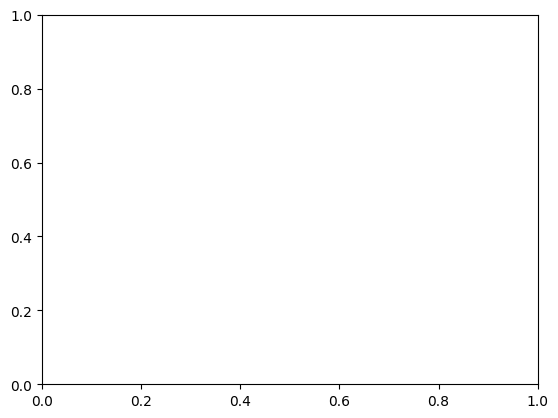

In [22]:
df_training_avail.plot(kind="scatter", x="WER (dev-other)", y="CTC")

<Axes: xlabel='WER (dev-other)', ylabel='dev CTC'>

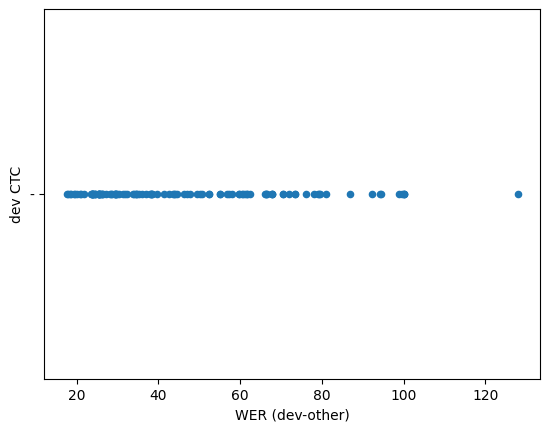

In [ ]:
df_training_avail.plot(kind="scatter", x="WER (dev-other)", y="dev CTC")

In [ ]:
df_training_avail[df_training_avail["overfitting"] < 100].plot(kind="scatter", x="WER (dev-other)", y="overfitting")

TypeError: '<' not supported between instances of 'str' and 'int'